In [1]:
# Install required python packages

# For Linux and Mac
#!pip install -U "qiskit[visualization]", qiskit_ibm_runtime

#!pip install networkx

#!pip install docplex

# %pip install pyyaml

# %pip install python-dotenv

In [2]:
# All imports
import sys
import os

sys.path.append(os.path.abspath(".."))

import rustworkx as rx
from rustworkx.visualization import mpl_draw as draw_graph
import numpy as np
import networkx as nx
import heapq
import json

from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
from qiskit.quantum_info import SparsePauliOp
from qiskit.providers.basic_provider import BasicProvider
from qiskit_ibm_runtime import Session, EstimatorV2 as Estimator
from qiskit_aer import AerSimulator
from scipy.optimize import minimize
from qiskit.circuit.parametervector import ParameterVector
from qiskit.circuit.library import QuadraticForm
from qiskit.circuit.library import qaoa_ansatz
from qiskit_ibm_runtime.fake_provider import FakeSherbrooke

import matplotlib.pyplot as plt
import matplotlib
from scipy.optimize import minimize

from docplex.mp.model import Model

from qiskit_ibm_runtime import SamplerV2 as Sampler

from typing import Sequence

from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

import time

import pickle
import seaborn as sns
from qiskit.visualization import plot_histogram

from src.quantum_algorithms.qumda_circuit import QUMDA
from src.quantum_algorithms.qaoa_circuit import QAOA

from dotenv import load_dotenv
from src.utils.config import *
from src.aux.aux import *
from src.utils.paths import PROJECT_ROOT, GRAPH_DIR, AER_SIM_DIR




In [3]:
# ## Save an IBM Quantum account and set it as your default account.
# load_dotenv()
# QiskitRuntimeService.save_account(

#     channel="ibm_quantum",

#     token= os.getenv("API_TOKEN"),

#     set_as_default=True,

#     # Use `overwrite=True` if you're updating your token.
#     overwrite=True,
# )

# # Load saved credentials
# service = QiskitRuntimeService()

In [4]:
service = QiskitRuntimeService(instance=os.getenv("INSTANCE"))

# Parameters

In [5]:
config = load_config()

qaoa_type = config["qaoa_parameters"]["type"]
p = config["qaoa_parameters"]["p"]
classical_optimizer = config["classical_optimizer"]
initial_gamma = config["qaoa_parameters"]["initial_gamma"]
initial_beta = config["qaoa_parameters"]["initial_beta"]
initial_theta = config["qaoa_parameters"]["initial_theta"]

hardware = config["hardware"]

noise = config["noise"]

min_cost = float('inf')
ITERATION_MAX = 30

loaded_data = read_pickle_files_from_directory(GRAPH_DIR)
sorted_loaded_data = dict(
    sorted(
        loaded_data.items(),
        key=lambda item: int(item[0].split('_')[0])
    )
)

graphs_str = get_graphs_name(sorted_loaded_data)
qaoa_type_index = 2
graph_index = 0
name_str = qaoa_type[qaoa_type_index]
graph_name = graphs_str[graph_index]
graph_sample = sorted_loaded_data[graphs_str[graph_index]]

n = number_qubits(graph_name)

In [6]:
max_cut_graph = build_max_cut_paulis(graph_sample)
cost_hamiltonian = SparsePauliOp.from_list(max_cut_graph)
print(cost_hamiltonian)

SparsePauliOp(['IIZIZ', 'IZIIZ', 'IIZZI', 'ZIIZI', 'ZIZII', 'ZZIII'],
              coeffs=[1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j])


5_graph_5


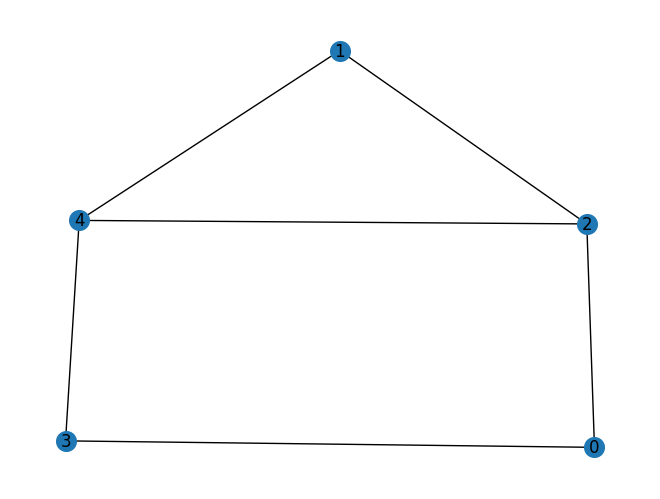

In [7]:
draw_graph(graph_sample, node_size=200, with_labels=True, width=1)
print(graph_name)

In [8]:
qumda_test = QUMDA(p,n, cost_hamiltonian)
#qumda_test_h = qumda_test.update_distribution([0.5]*n)
qumda_test_h = qumda_test.update_distribution([0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5])

In [9]:
qaoa_ansatz = qaoa_ansatz(cost_hamiltonian, reps=1, insert_barriers=True)   #QAOA

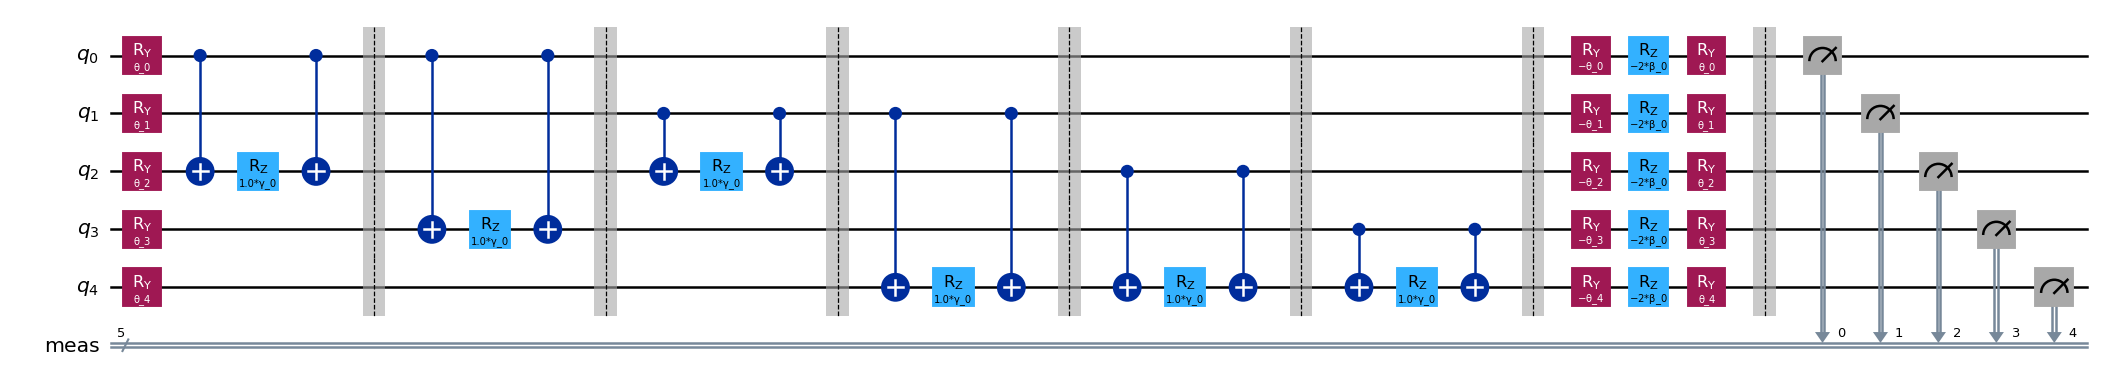

In [10]:
qumda_test.qc.draw('mpl', fold=False, scale=0.9, idle_wires=False)

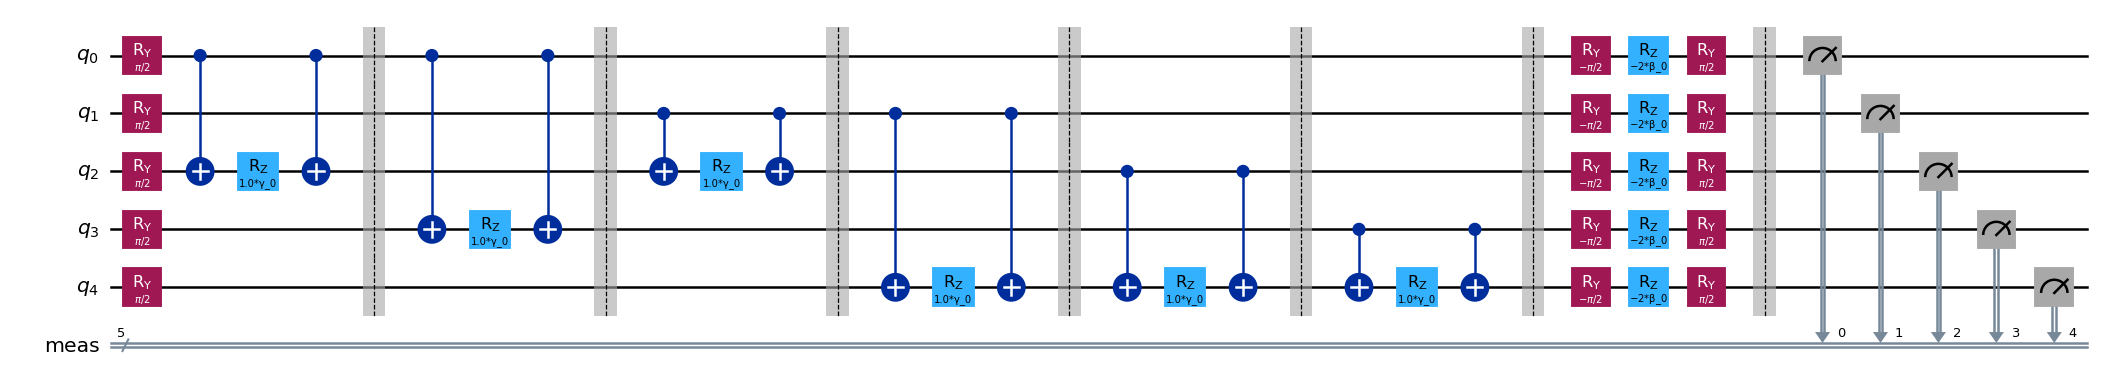

In [11]:
qumda_test_h.draw('mpl', fold=False, scale=0.9, idle_wires=False)

In [12]:
if hardware:
  chosen_backend = service.least_busy(simulator=False, operational=True)
else:
  if noise:
    chosen_backend = FakeSherbrooke()
    chosen_backend.refresh(service)
  else:
    chosen_backend = AerSimulator()

pm = generate_preset_pass_manager(optimization_level = 2, backend=chosen_backend)

candidate_circuit_max_cut = pm.run(qumda_test.qc)
candidate_circuit_max_cut_h = pm.run(qumda_test_h)
#candidate_qaoa = pm.run(qaoa_ansatz)

transpile_observable = cost_hamiltonian.apply_layout(layout=candidate_circuit_max_cut.layout)
transpile_observable_h = cost_hamiltonian.apply_layout(layout=candidate_circuit_max_cut_h.layout)
#transpile_qaoa_obs = cost_hamiltonian.apply_layout(layout=candidate_circuit_max_cut.layout)


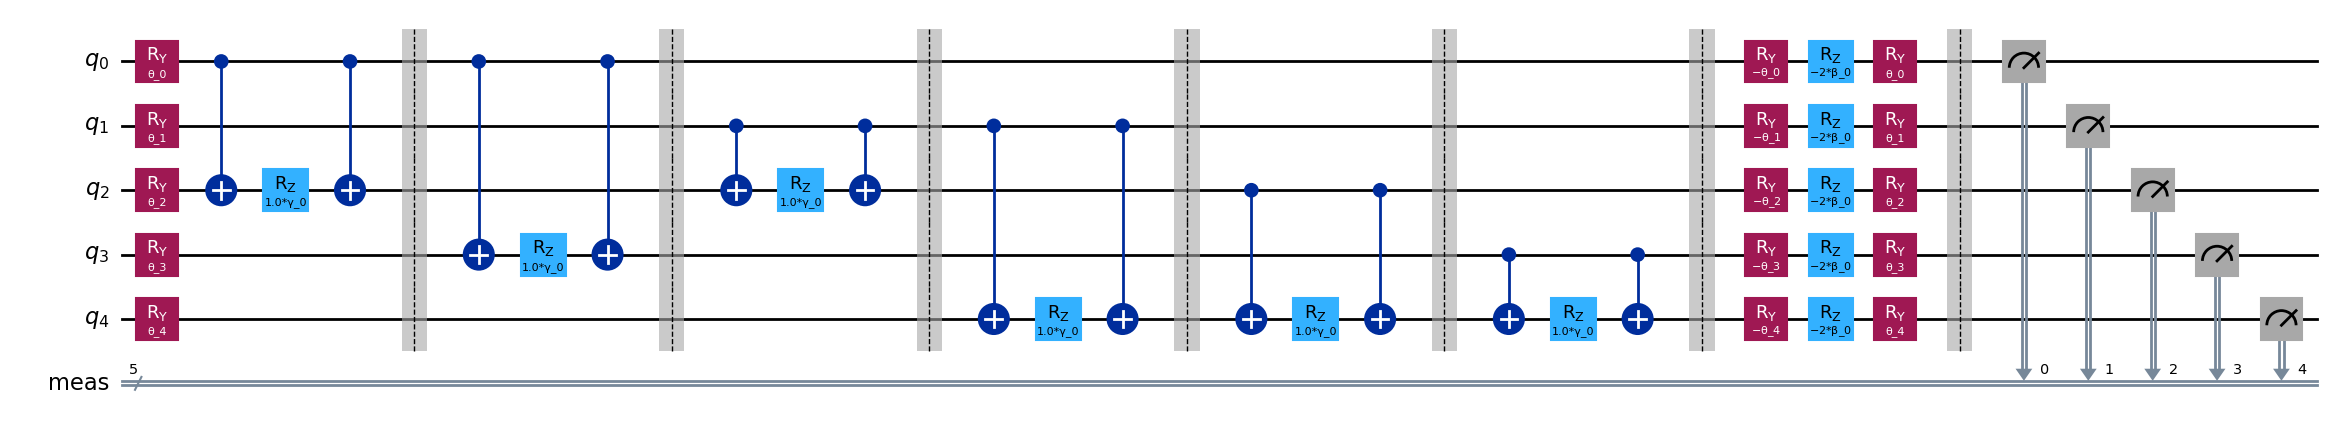

In [13]:
candidate_circuit_max_cut.draw('mpl', fold=False, scale=1.0, idle_wires=False)

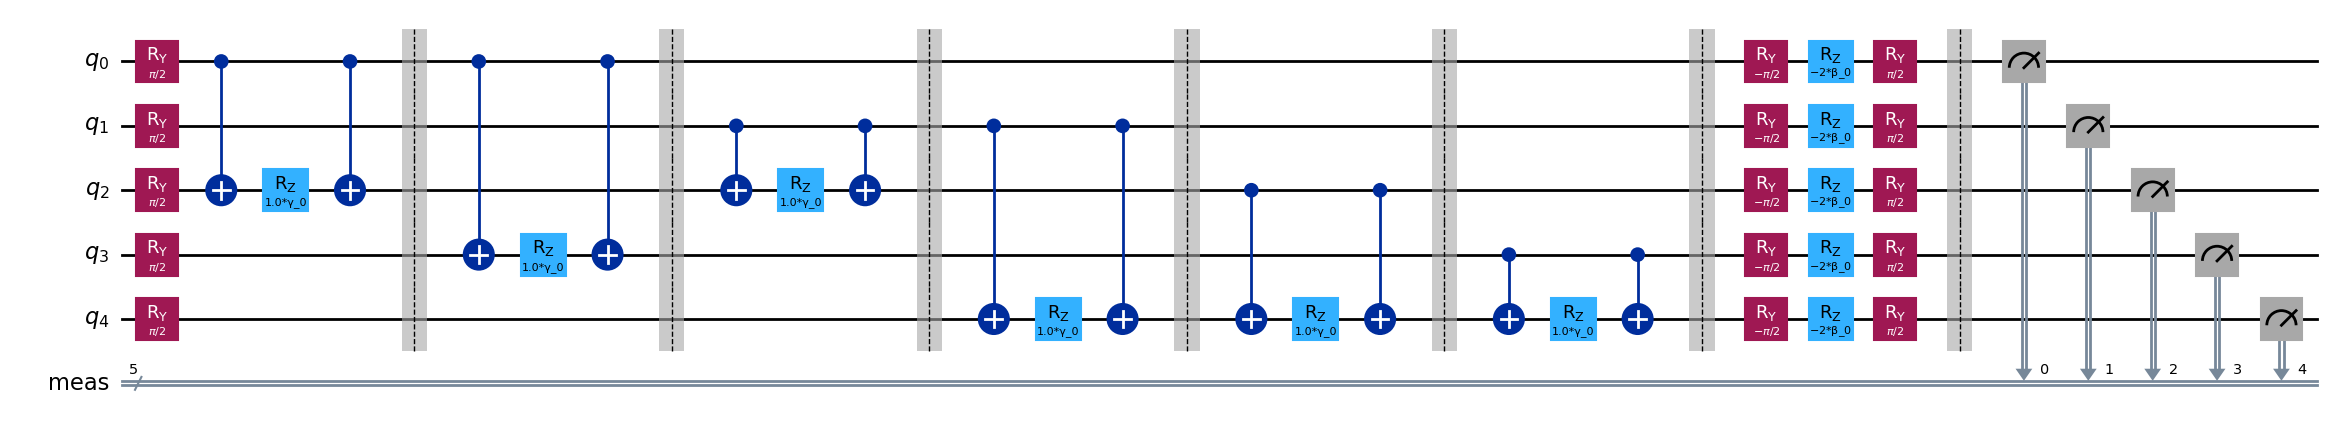

In [14]:
candidate_circuit_max_cut_h.draw('mpl', fold=False, scale=1.0, idle_wires=False)

In [15]:
def cost_function(params, ansatz, hamiltonian, estimator):

    # transform the observable defined on virtual qubits to
    # an observable defined on all physical qubits
    #isa_hamiltonian = hamiltonian.apply_layout(ansatz.layout)
    #pub = (ansatz, isa_hamiltonian, params)
    global pv

    if qaoa_type_index == 2:
      ansatz = qumda_test.update_distribution2(ansatz, pv)
      jobs = sampler.run([(ansatz, params)])
      results2 = jobs.result()[0]
      samp_dist = results2.data.meas.get_counts()
      pv = UpdateProbabilityVectorCostFunction(samp_dist, 4, n, transpile_obs, n)
      counts.append(samp_dist)

    else:
        jobs = sampler.run([(ansatz, params)])
        results2 = jobs.result()[0]
        samp_dist = results2.data.meas.get_counts()
        counts.append(samp_dist)

    pub = (ansatz, hamiltonian, params)
    job = estimator.run([pub])

    results = job.result()[0]
    cost = results.data.evs

    objective_func_vals.append(cost)


    return cost

In [16]:

init_params = [initial_gamma, initial_beta]
start = time.perf_counter()

if qaoa_type_index == 3:
    [init_params.append(initial_theta) for i in range(qumda_test.n_qubits)]

objective_func_vals = [] # Global variable
counts = [] #Global variable
pv = [0.5] * qumda_test.n_qubits #Global variable

if qaoa_type_index <= 1:
    candidate = candidate_circuit_max_cut_h
    transpile_obs = transpile_observable_h
    #candidate = candidate_qaoa
    #transpile_obs = transpile_qaoa_obs


else:
    candidate = candidate_circuit_max_cut
    transpile_obs = transpile_observable
    #candidate = candidate_qaoa
    #transpile_obs = transpile_qaoa_obs

with Session(backend=chosen_backend) as session:
    # If using qiskit-ibm-runtime<0.24.0, change `mode=` to `session=`
    estimator = Estimator(mode=session)


    sampler = Sampler(mode=chosen_backend)

    estimator.options.default_shots = 10000
    sampler.options.default_shots = 10000

    # Set simple error suppression/mitigation options
    #estimator.options.dynamical_decoupling.enable = True
    #estimator.options.dynamical_decoupling.sequence_type = "XY4"
    #estimator.options.twirling.enable_gates = True
    #estimator.options.twirling.num_randomizations = "auto"

    if qaoa_type_index == 1:
        for i in range(ITERATION_MAX):

            cost = cost_function(init_params, candidate, transpile_obs, estimator)

            if min_cost > cost:
                result = init_params

            for i in range(len(init_params)):
                init_params[i] = np.random.uniform(-np.pi, np.pi)

        result_x = result

    else:
        result = minimize(
            cost_function,
            init_params,
            args=(candidate, transpile_obs, estimator),
            method= "COBYLA",
            options={'maxiter':35}
        )
        print(result)
        result_x = result.x




 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -2.3680000000000003
       x: [ 8.739e-01  2.900e-01]
    nfev: 30
   maxcv: 0.0


In [ ]:
#Optimal circuit
if qaoa_type_index == 2:
    candidate = qumda_test.update_distribution2(candidate, pv)
optimized_circuit_max_cut = candidate.assign_parameters(result_x)

#Sample of circuit
sampler = Sampler(mode=chosen_backend)
sampler.options.default_shots = 10000
pub= (optimized_circuit_max_cut, )
#job = sampler.run([pub], shots=int(1e4))
job = sampler.run([pub])

counts_int = job.result()[0].data.meas.get_int_counts()
shots = sum(counts_int.values())
final_distribution = {key: val/shots for key, val in counts_int.items()}

#Best solution
best_solution = best_sample(final_distribution, cost_hamiltonian)
best_solution_string = to_bitstring(int(best_solution), len(graph_sample))
best_solution_string.reverse()

#Cut value
cut_value= evaluate_sample(best_solution_string, graph_sample)

end = time.perf_counter()
elapsed = end - start


In [ ]:
#Save result
file_name = graph_name +': '+ name_str
obj_func_cost = []
results_x = []
sample_dist = []

for i in objective_func_vals:
    obj_func_cost.append(float(i))

for i in result_x:
    results_x.append(float(i))

qaoa_results = {
    "file_name": file_name,
    "objective_func_cost": obj_func_cost,
    "sample_distribution" : counts,
    "optimal_parameters" : results_x,
    "beste_result_bitstring": best_solution_string,
    "value_of_cut": cut_value,
    "elapsed_time_seconds": round(elapsed, 4),
    "final_distribution" : final_distribution
}

file_path = os.path.join(AER_SIM_DIR, file_name+".json")

with open(file_path, "w") as f:
    json.dump(qaoa_results, f, indent=4)

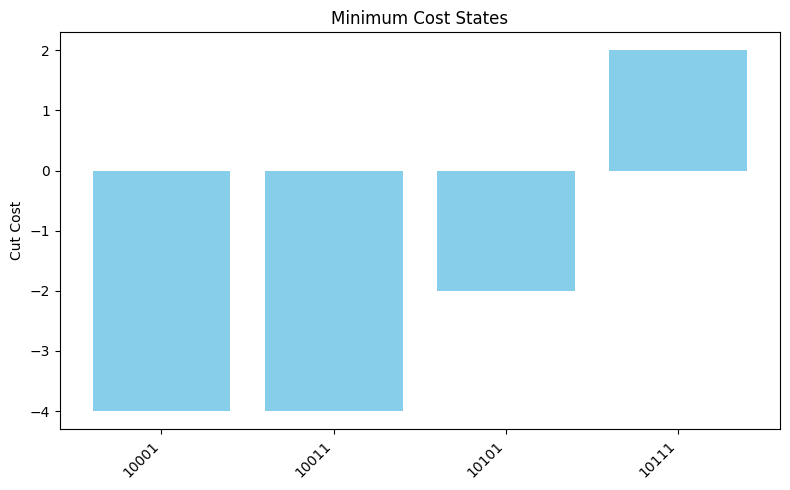

In [30]:
import matplotlib.pyplot as plt

def int_to_binary(n, bits=None):
    if bits:
        return format(n, f'0{bits}b')
    else:
        return bin(n)[2:]

# Convert probabilities to integer counts based on number of shots
counts = {key: int(prob * shots) for key, prob in final_distribution.items()}

# Sort by counts in descending order (all items if needed)
top_items = sorted(counts.items(), key=lambda item: item[1], reverse=True)

# Step 2: Evaluate cost for each bitstring
evaluated = []
for sample_int, _ in top_items:  # sample_int is already an integer
    cost = calculate_cost(sample_int, cost_hamiltonian)
    evaluated.append((sample_int, cost))

# Step 3: Sort by cost (lowest first)
sorted_by_cost = sorted(evaluated, key=lambda x: x[1])

# Separate integers and costs
bit_ints, bit_costs = zip(*sorted_by_cost)

# Get max bit length of all integers for padding
max_bits = max(b.bit_length() for b in bit_ints)

# Convert to binary strings with padding
binary_labels = tuple(int_to_binary(b, bits=max_bits) for b in bit_ints)

# Plotting
x = range(len(bit_ints))
plt.figure(figsize=(8, 5))
plt.bar(x, bit_costs, color='skyblue')
plt.xticks(ticks=x, labels=binary_labels, rotation=45, ha='right')
plt.ylabel("Cut Cost")
plt.title("Minimum Cost States")
plt.tight_layout()
plt.show()



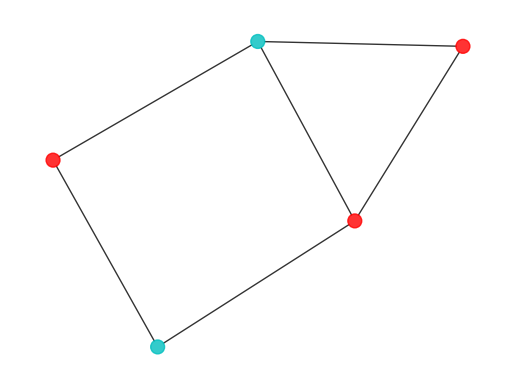

In [19]:
plot_result(graph_sample, best_solution_string, n)

In [22]:
final_dis = final_distribution

# Sort the distribution by value (frequency) descending
top_items = sorted(final_dis.items(), key=lambda item: item[1], reverse=True)

all_costs = []

for sample, freq in top_items:
    sample_int = int(sample)
    cost = calculate_cost(sample_int, cost_hamiltonian)
    all_costs.append(cost)
    #print(f"Sample: {sample}, Cost: {cost}")

# Calculate average cost
avg_cost = np.mean(all_costs)
print(f"Average Cost: {avg_cost}")
#print(len(all_costs))

# Calculate average cost 10
avg_cost = np.mean(all_costs[:10])
print(f"Average Cost: {avg_cost}")
#print(len(all_costs))


best_solution = best_sample(final_dis, cost_hamiltonian)
print(best_solution)
best_solution_string = to_bitstring(int(best_solution), len(graph_sample))
best_solution_string.reverse()


# Evaluate cut value for the best solution
cut_value = evaluate_sample(best_solution_string, graph_sample)
print(cut_value)



Average Cost: -2.0
Average Cost: -2.0
17
5
